# K-Means Clustering — No-Framework Implementation

Building K-Means from scratch using only NumPy. This is the most educational implementation — we manually code every component of the algorithm.

**Dataset**: Dry Beans — 13,543 samples, 16 geometric features, 7 bean types.

## What We'll Build From Scratch
- **K-Means++ initialization** — smart centroid seeding (probability ∝ distance²)
- **Cluster assignment** — vectorized Euclidean distance via broadcasting
- **Centroid update** — mean of assigned samples + empty cluster handling
- **Lloyd's algorithm** — the iterative assign → update → converge loop
- **Multi-init wrapper** — n_init runs, keep best by inertia


In [1]:
import sys
import os
import numpy as np

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance
from utils.visualization import (plot_elbow_curve, plot_silhouette_comparison,
                                  plot_silhouette_analysis, plot_convergence_curve)
from utils.results import save_results, add_result, print_comparison
from utils.metrics import inertia, silhouette_score, adjusted_rand_index

# Configuration
RANDOM_STATE = 113
K_RANGE = range(2, 13)       # Test K=2 through K=12
MAX_ITER = 300
TOL = 1e-4
N_INIT = 5                   # 5 random initializations, keep best by inertia
FRAMEWORK = 'No-Framework'

# Load preprocessed data
X_train, X_test, y_train, y_test, meta = load_processed_data('kmeans')

print("=" * 60)
print(f"K-MEANS — {FRAMEWORK}")
print("=" * 60)
print(f"Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test:     {X_test.shape[0]:,} samples")
print(f"Classes:  {meta['n_classes']} ({meta['class_names']})")

K-MEANS — No-Framework
Training: 10,834 samples, 16 features
Test:     2,709 samples
Classes:  7 (['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])


In [2]:
# Step 1: K-Means++ initalization

def kmeans_plus_plus_init(X, k, rng):
    """
    Select k initial centroids using k-means++ algo.

    First centroid is chosen randomly. Each subsequent centroid is 
    chosen with probability prorportional to D(x)^2 - the squared
    distance to the nearest existing centroid. This spreads centroids
    apart for faster, more reliable convergence.

    Args:
        X: training data (n_samples, n_featres)
        k: Number of clusters
        rng: np.random.Randomstate for reproducibility

    Returns:
        centroids: initial centroid positions (k, n_features)
    """
    n_samples, n_features = X.shape
    centroids = np.empty((k, n_features))

    # First centroid: random data point
    first_idx = rng.randint(0, n_samples)
    centroids[0] = X[first_idx]

    # Remaining centroids: weighted by squared distance
    for c in range(1, k):
        # Squared distance from each point to nearest existing centroid
        diff = X[:, np.newaxis, :] - centroids[np.newaxis, :c, :]
        sq_distances = np.sum(diff ** 2, axis=2)

        # Distance to nearest centroid for each point
        min_sq_dist = np.min(sq_distances, axis=1)

        # Convert to probabilities
        probs = min_sq_dist / min_sq_dist.sum()

        # Choose next centroid using weighted probability
        next_idx = rng.choice(n_samples, p=probs)
        centroids[c] = X[next_idx]

    return centroids

# Quick test
rng = np.random.RandomState(RANDOM_STATE)
test_centroids = kmeans_plus_plus_init(X_train, k=3, rng=rng)
print(f"Centroids shape: {test_centroids.shape}")
print(f"First centroid: {test_centroids[0][:5]}...")
print(f"Centroids are unique: {len(np.unique(test_centroids, axis=0)) == 3}")

Centroids shape: (3, 16)
First centroid: [ 0.1160314   0.49730625  0.79295167 -0.35469757  2.0429446 ]...
Centroids are unique: True


## Lloyd's Algorithm (Core K-Means Loop)

The iterative heart of K-Means. Each iteration has two steps:

1. **Assign** — For each data point, find the nearest centroid (Euclidean distance). This assigns every point to a cluster.
2. **Update** — Recompute each centroid as the mean of all points assigned to it.

Repeat until centroids stop moving (convergence) or max iterations reached.

**Convergence check:** Max centroid displacement < tolerance (1e-4). If no centroid moves more than this threshold, the algorithm has stabilized.


In [4]:
# Step 2: Assign clusters - find nearest centroid for each point

def assign_clusters(X, centroids):
    """
    Assign each sample to its nearest centroid using euclidean distance.

    Vectorized via broadcasting:
        X: (n_samples, n_features) -> (n_samples, 1, n_features)
        centroids: (k, n_features) -> (1, k, n_features)
        diff: (n_samples, k, n_features) - all pairwise differences
    
    Args:
        X: data points (n_samples, n_features)
        centroids: current centroid position (k, n_features)

    Returns:
        labels: cluster assignment for each sample (n_samples,)
        distances: distance from each sample to  its assigned centroid (n_samples,)
    """
    # Broadcasting: compute distance from every point to every centroid
    diff = X[:, np.newaxis, :] - centroids[np.newaxis, :, :]
    sq_distances = np.sum(diff ** 2, axis=2)    # (n_samples, k)

    # Each point gets assigned to the closest centroid
    labels = np.argmin(sq_distances, axis=1)

    # distance to assigned centroid (for inertia calculation)
    distances = sq_distances[np.arange(len(X)), labels]

    return labels, distances

# Quick test
test_labels, test_dists = assign_clusters(X_train[:10], test_centroids)
print(f"Labels shape: {test_labels.shape}")
print(f"Labels: {test_labels}")
print(f"Distances shape: {test_dists.shape}")
print(f"All distances positive: {np.all(test_dists >= 0)}")

Labels shape: (10,)
Labels: [0 0 0 0 0 2 0 2 2 2]
Distances shape: (10,)
All distances positive: True


In [6]:
# Step 3: Update centroids - recompute as mean of assigned samples

def update_centroids(X, labels, k, rng):
    """
    Recompute each centroid as the mean of its assigned samples.

    Edge case: if a cluster has no samples assigned (empty cluster),
    reinitalize it to a random data point. This prevents NaN centroids
    and keep all k clusters active.

    Args:
        X: data points (n_samples, n_features)
        labels: current cluster assignemnts (n_samples,)
        k: number of clusters
        rng: np.random.RandomState for empty cluster reinitialization

    Returns:
        centroids: updated centroid positions (k, n_features)
    """
    n_features = X.shape[1]
    centroids = np.empty((k, n_features))

    for c in range(k):
        mask = labels == c
        if np.sum(mask) > 0:
            centroids[c] = X[mask].mean(axis=0)
        else:
            # Empty cluster: reinitialize to random data point
            centroids[c] = X[rng.randint(0, len(X))]
    
    return centroids

# Quick test
rng = np.random.RandomState(RANDOM_STATE)
test_updated = update_centroids(X_train[:10], test_labels, k=3, rng=rng)
print(f"Updated centroids shape: {test_updated.shape}")
print(f"No NaN values: {not np.any(np.isnan(test_updated))}")

Updated centroids shape: (3, 16)
No NaN values: True


In [ ]:
# Step 4: single run of lloyds algorithm

def kmeans_single_run(X, k, max_iter=300, tol=1e-4, rng=None):
    """
    One complete run of k-means: initialize, then iterate assign/update.

    Lloyds algorithm loop:
        1. initailize centroids (k-means++)
        2. assign each point to nearest centroid
        3. update centroids as cluster means
        4. check convergence: if max centroid shift < tol, stop
        5. repeat 2-4 until converged or max_iter reached
    
    Args:
        X: training data (n_samples, n_features)
        k: number of clusters
        max_iter: maximum iterations before stopping
        tol: convergence threshold - max centroid displacement
        rng: np.random.RandomState for reproducibility

    Returns:
        centroids: final centroid positions (k, n_features)
        labels: final cluster assignments (n_samples,)
        final_inertia: sum of squared distances to centroids
        n_iter: number of iterations completed
        inertia_history: inertia at each iteration (for convergence plot)
    """
    # initialize centroids using k-means++
    centroids = kmeans_plus_plus_init(X, k, rng)
    inertia_history = []

    for iteration in range(1, max_iter + 1):
        # assign step
        labels, distances = assign_clusters(X, centroids)
        current_inertia = np.sum(distances)
        inertia_history.append(current_inertia)

        # update step
        new_centroids = update_centroids(X, labels, k, rng)

        # convergence check: max centroid displacement
        shift = np.max(np.sqrt(np.sum((new_centroids - centroids) ** 2, axis=1)))
        centroids = new_centroids

        if shift < tol:
            break

    return centroids, labels, current_inertia, iteration, inertia_history # type: ignore

# Quick test with small k
rng = np.random.RandomState(RANDOM_STATE)
cents, labs, inert, n_it, hist = kmeans_single_run(X_train, k=3, rng=rng)
print(f"Converged in {n_it} iterations")
print(f"Final inertia: {inert:,.2f}")
print(f"Inertia history length: {len(hist)}")
print(f"Inertia decreased: {hist[0] > hist[-1]}")

Converged in 7 iterations
Final inertia: 75,557.90
Inertia history length: 7
Inertia decreased: True


In [ ]:
# Step 5: Multi-init k-means wrapper

def kmeans(X, k, n_init=5, max_iter=300, tol=1e-4, random_state=113):
    """
    Run k-means n_init times, keep the best result by lowest inertia.

    Each run uses a different random seed (random_state + 1) so
    initializaions very but results are reproducible. This reduces
    sensitivity to unlucky starting positions.

    Args:
        X: training data (n_samples, n_features)
        k: number of clusters
        n_init: number of independent runs
        max_iter: max iterations per run
        tol: convergence threshold per run
        random_state base seed (run 1 uses random_state + 1)

    Returns:
        best_centroids: centroids from the best run (k, n_features)
        best_labels: labels from the best run (n_samples,)
        best_inertia: lowest inertia achieved
        best_n_iter: iterations of the best run
        best_history: inertia history of the best run
    """
    best_inertia = np.inf
    best_centroids = None
    best_labels = None
    best_n_iter = None
    best_history = None

    for i in range(n_init):
        rng = np.random.RandomState(random_state + i)
        centroids, labels, run_inertia, n_iter, history = kmeans_single_run(
            X, k, max_iter, tol, rng
        )

        if run_inertia < best_inertia:
            best_inertia = run_inertia
            best_centroids = centroids
            best_labels = labels
            best_n_iter = n_iter
            best_history = history

    return best_centroids, best_labels, best_inertia, best_n_iter, best_history

# Quick test
cents, labs, inert, n_it, hist = kmeans(X_train, k=3, n_init=3)
print(f"Best of 3 runs:")
print(f"  Inertia:    {inert:,.2f}")
print(f"  Iterations: {n_it}")
print(f"  Clusters:   {np.unique(labs)}") # type: ignore

Best of 3 runs:
  Inertia:    75,557.90
  Iterations: 7
  Clusters:   [0 1 2]


In [ ]:
# Step 6: K-tuning - test k=2 through k=12
print("=" * 60)
print("K-TUNING: Testing K=2 through K=12")
print("=" * 60)

tuning_inertias = []
tuning_sil_scores = []
k_list = list(K_RANGE)

for k in k_list:
    cents, labs, inert, n_it, hist = kmeans(
        X_train, k, n_init=N_INIT, max_iter=MAX_ITER,
        tol=TOL, random_state=RANDOM_STATE
    )

    tuning_inertias.append(inert)
    sil = silhouette_score(X_train, labs)
    tuning_sil_scores.append(sil)

    print(f"    K={k:2d} | Inertia: {inert:,.1f} | Silhouette: {sil:.4f} | Iters: {n_it}")

print(f"\nTuning complete.")

K-TUNING: Testing K=2 through K=12
    K= 2 | Inertia: 103,635.7 | Silhouette: 0.3965 | Iters: 6
    K= 3 | Inertia: 75,557.9 | Silhouette: 0.4034 | Iters: 7
    K= 4 | Inertia: 60,743.3 | Silhouette: 0.3428 | Iters: 37
    K= 5 | Inertia: 49,175.7 | Silhouette: 0.3582 | Iters: 25
    K= 6 | Inertia: 43,871.6 | Silhouette: 0.3611 | Iters: 16
    K= 7 | Inertia: 38,925.5 | Silhouette: 0.3084 | Iters: 19
    K= 8 | Inertia: 36,050.2 | Silhouette: 0.3028 | Iters: 32
    K= 9 | Inertia: 33,511.5 | Silhouette: 0.3030 | Iters: 17
    K=10 | Inertia: 31,720.0 | Silhouette: 0.2879 | Iters: 56
    K=11 | Inertia: 30,242.8 | Silhouette: 0.2864 | Iters: 30
    K=12 | Inertia: 28,836.3 | Silhouette: 0.2618 | Iters: 87

Tuning complete.


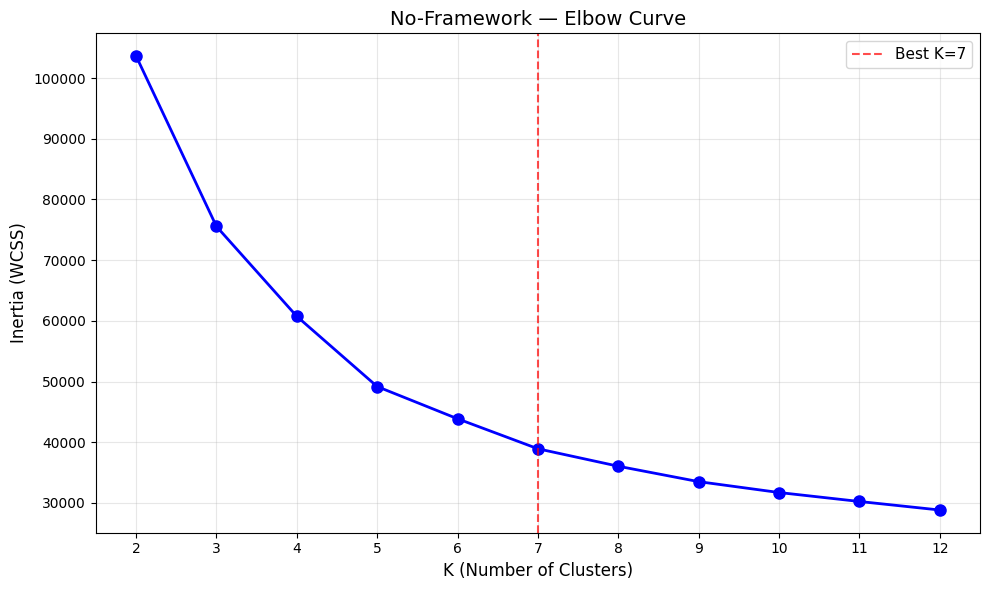

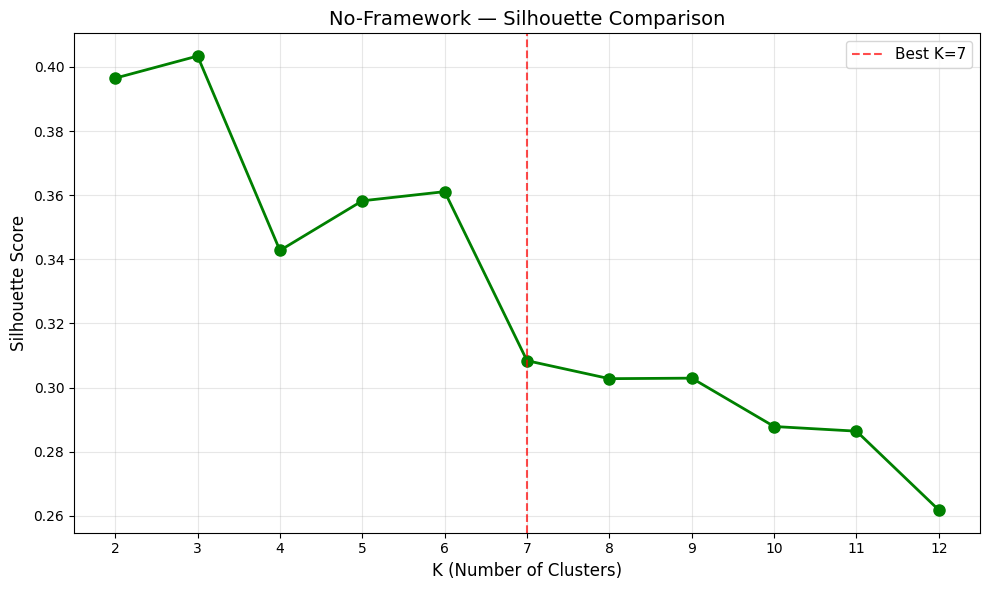

Geometric optimum:  K=3 (Silhouette: 0.4034)
Ground truth match: K=7 (Silhouette: 0.3084)
Selected: K=7 — matches actual bean class count for ARI evaluation


In [10]:
# Step 7: visualize k-tuning results

plot_elbow_curve(k_list, tuning_inertias, FRAMEWORK, best_k=7,
                 save_path='results/elbow_curve.png')
plot_silhouette_comparison(k_list, tuning_sil_scores, FRAMEWORK, best_k=7,
                           save_path='results/silhouette_comparison.png')

print(f"Geometric optimum:  K=3 (Silhouette: {tuning_sil_scores[1]:.4f})")
print(f"Ground truth match: K=7 (Silhouette: {tuning_sil_scores[5]:.4f})")
print(f"Selected: K=7 — matches actual bean class count for ARI evaluation")

In [11]:
# Step 8: Train final model (k=7)

with track_performance(gpu=False) as perf:
    centroids, train_labels, final_inertia, n_iter, inertia_hist = kmeans(
        X_train, k=7, n_init=N_INIT, max_iter=MAX_ITER,
        tol=TOL, random_state=RANDOM_STATE
    )

print("=" * 60)
print("FINAL MODEL TRAINED (K=7)")
print("=" * 60)
print(f"Iterations:    {n_iter}")
print(f"Inertia:       {final_inertia:,.2f}")
print(f"Training time: {perf['time']:.4f}s")
print(f"Peak memory:   {perf['memory']:.2f} MB")

FINAL MODEL TRAINED (K=7)
Iterations:    19
Inertia:       38,925.51
Training time: 1.0159s
Peak memory:   19.44 MB


In [12]:
# Step 9: Assign test samples to nearest centroids

test_labels, _ = assign_clusters(X_test, centroids)

print("=" * 60)
print("TEST SET CLUSTER ASSIGNMENTS")
print("=" * 60)
print(f"Train clusters: {np.unique(train_labels)}") # type: ignore
print(f"Test clusters:  {np.unique(test_labels)}")
print(f"Train samples per cluster:")
for c in range(7):
    count = np.sum(train_labels == c)
    print(f"    Cluster {c}: {count:,} ({count/len(train_labels)*100:.1f}%)") # type: ignore

TEST SET CLUSTER ASSIGNMENTS
Train clusters: [0 1 2 3 4 5 6]
Test clusters:  [0 1 2 3 4 5 6]
Train samples per cluster:
    Cluster 0: 1,632 (15.1%)
    Cluster 1: 416 (3.8%)
    Cluster 2: 2,509 (23.2%)
    Cluster 3: 2,495 (23.0%)
    Cluster 4: 1,971 (18.2%)
    Cluster 5: 436 (4.0%)
    Cluster 6: 1,375 (12.7%)


In [13]:
# Step 10: Evaluate clustering quality

train_inertia = inertia(X_train, train_labels, centroids)
test_inertia = inertia(X_test, test_labels, centroids)

train_sil = silhouette_score(X_train, train_labels)
test_sil = silhouette_score(X_test, test_labels)

train_ari = adjusted_rand_index(y_train, train_labels)
test_ari = adjusted_rand_index(y_test, test_labels)

print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"{'Metric':<20} {'Train':>10} {'Test':>10}")
print("-" * 40)
print(f"{'Inertia':<20} {train_inertia:>10,.2f} {test_inertia:>10,.2f}")
print(f"{'Silhouette':<20} {train_sil:>10.4f} {test_sil:>10.4f}")
print(f"{'ARI':<20} {train_ari:>10.4f} {test_ari:>10.4f}")

EVALUATION METRICS
Metric                    Train       Test
----------------------------------------
Inertia               38,925.51   9,976.28
Silhouette               0.3084     0.3064
ARI                      0.6660     0.6684


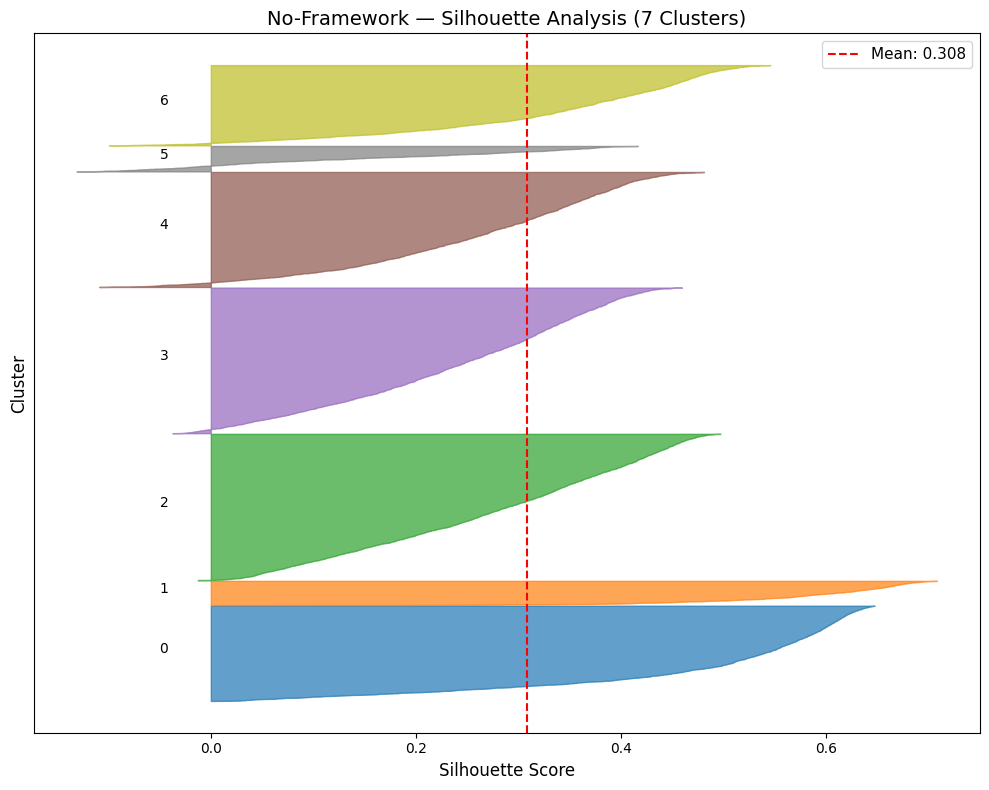

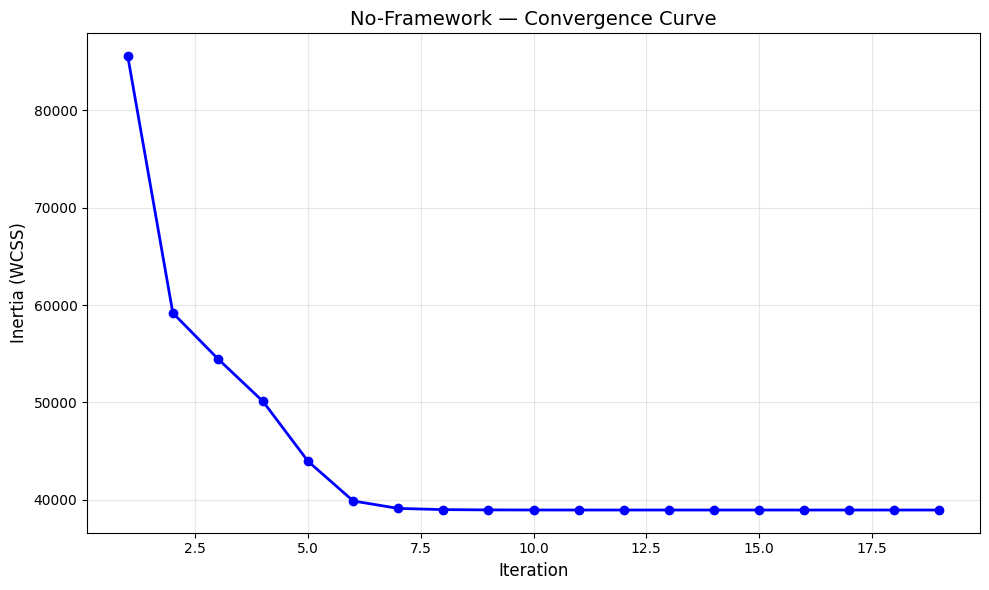

Silhouette analysis and convergence plotted.
Convergence: 19 iterations tracked


In [ ]:
# Step 11: Visualizations - silhouette analysis + convergence

plot_silhouette_analysis(X_train, train_labels, FRAMEWORK,
                         save_path='results/silhouette_analysis.png')

""" 
Convergence curve comes directly from inertia_history — no workaround
needed like in Scikit-Learn. Our from-scratch implementation naturally
tracks inertia at each iteration.
"""

plot_convergence_curve(inertia_hist, FRAMEWORK,
                       save_path='results/convergence_curve.png')

print(f"Silhouette analysis and convergence plotted.")
print(f"Convergence: {len(inertia_hist)} iterations tracked") # type: ignore

In [15]:
# Step 12: Save results and cross-framework comparison

results = {
    'framework': FRAMEWORK,
    'inertia': float(test_inertia),
    'silhouette': float(test_sil),
    'ari': float(test_ari),
    'iterations': int(n_iter),
    'training_time': float(perf['time']),
    'peak_memory_mb': float(perf['memory'])
}

save_results(results, 'results')
add_result('kmeans', results)

print(f"\nCross-framework comparison so far:")
print_comparison('kmeans')

    Results saved to: results\metrics.json
    Added 'No-Framework' to C:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\data\results\kmeans.json
    Frameworks recorded: 2/4

Cross-framework comparison so far:

CROSS-FRAMEWORK COMPARISON: KMEANS
Metric            Scikit-Learn  No-Framework
--------------------------------------------
inertia              9981.0642     9976.2848
silhouette              0.3061        0.3064
ari                     0.6686        0.6684
iterations                  26            19
training_time           0.0614        1.0159
peak_memory_mb          2.7105       19.4399

    Frameworks: 2/4 recorded
